In [4]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

### Plotting the distributions

In [32]:
FILE_PATH = 'annotations_gpt-4/annotations_gpt-4'

with open(f'{FILE_PATH}/experiment_type_to_prolific_id.json') as file:
    experiment_types = json.load(file)

website_preferences = experiment_types['website_preferences']

query_to_avgs = {}
for query_type in website_preferences:
    print("QUERY TYPE:", query_type)
    query_avgs = []

    for i, prolific_id in enumerate(website_preferences[query_type]):
        if (i == 0): continue
        with open(f'{FILE_PATH}/{prolific_id}.json') as file:
            person_data = json.load(file)

        history = person_data['conversation_history']
        person_times = np.array([])

        for item in history:
            if item['sender'] == 'user':
                time_spent = item['time_spent_ms'] / 1000
                person_times = np.append(person_times, [time_spent])
            else: # item['sender'] == 'assistant'
                continue

        query_avgs.append(np.mean(person_times))

    query_avgs.sort()
    query_to_avgs[query_type] = query_avgs


QUERY TYPE: Supervised Learning
QUERY TYPE: Non-interactive
QUERY TYPE: Pool-based Active Learning
QUERY TYPE: Generative edge cases
QUERY TYPE: Generative yes/no questions
QUERY TYPE: Generative open-ended questions


Supervised Learning
Responses: 30
Mean: 20.83878017437934
Median: 14.373390217391306


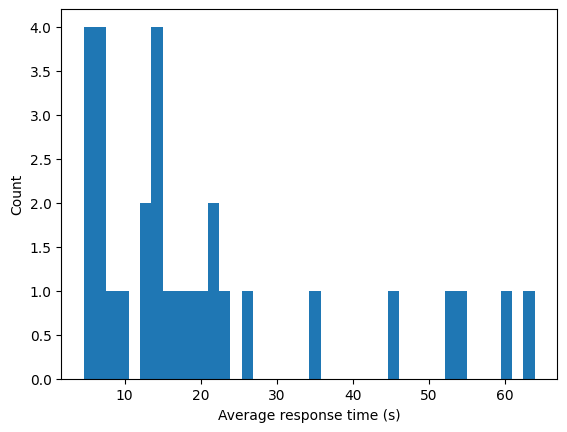

Non-interactive
Responses: 30
Mean: 228.94189999999998
Median: 214.582


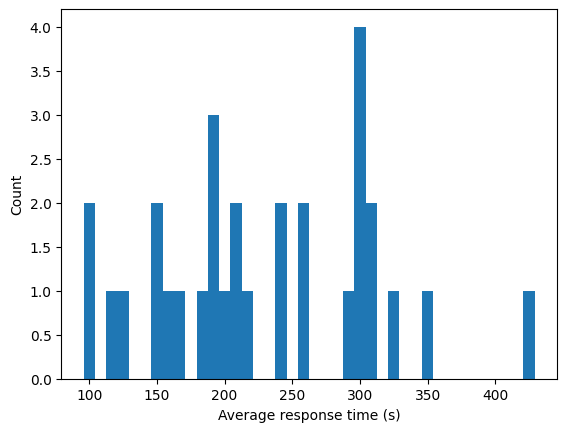

Pool-based Active Learning
Responses: 31
Mean: 23.733766838938394
Median: 17.618176470588235


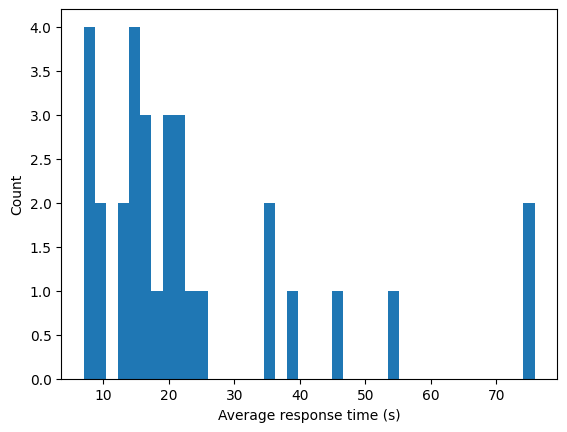

Generative edge cases
Responses: 30
Mean: 32.156100802206865
Median: 28.543172222222225


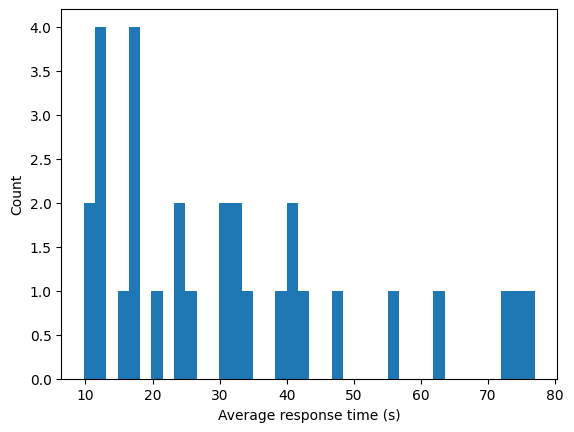

Generative yes/no questions
Responses: 31
Mean: 11.835075445684446
Median: 8.086121212121212


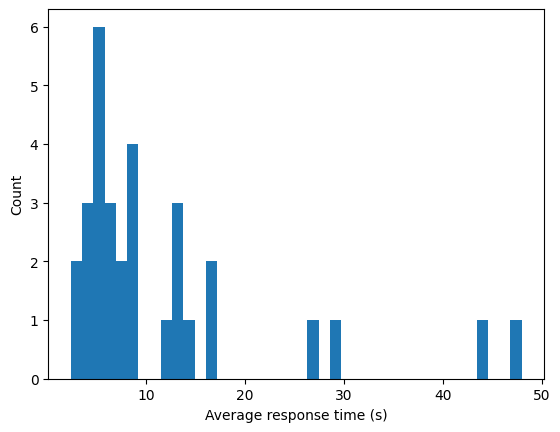

Generative open-ended questions
Responses: 31
Mean: 49.53692535224632
Median: 41.72971428571428


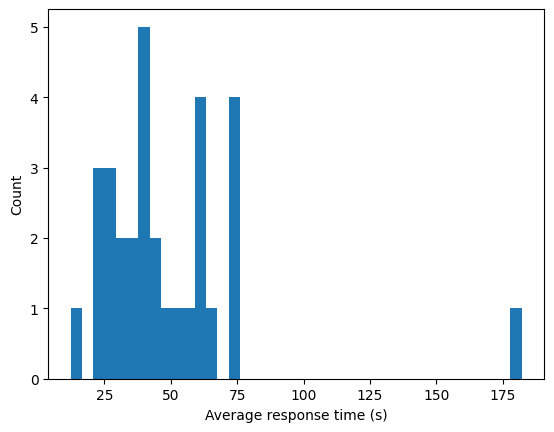

In [33]:
def plot_histogram(data):
    print("Responses:", len(data))
    print("Mean:", sum(data)/len(data))
    print("Median:", (data[len(data)//2]+data[(len(data)-1)//2])/2 )

    plt.hist(data, bins=40)
    plt.xlabel('Average response time (s)')
    plt.ylabel('Count')
    plt.show()

for query in query_to_avgs:
    print(query)
    plot_histogram(query_to_avgs[query])

Responses: 27
Mean: 55.56049210293204
Median: 24.32675


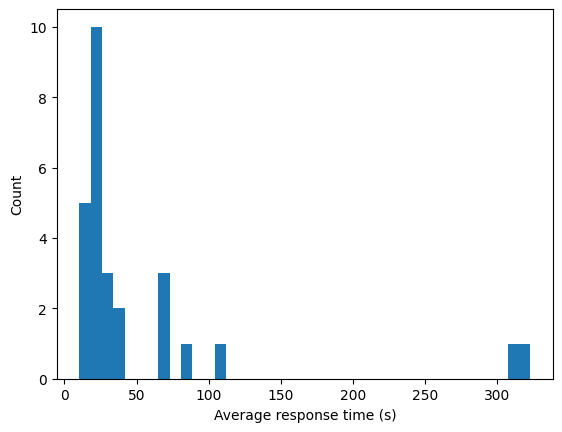

In [38]:
TRANSCRIPT_PATH = 'transcripts/transcripts/content_recommendation'

query_avgs = []
type = 'LM_open_ended'
for filename in os.listdir(f'{TRANSCRIPT_PATH}/{type}'):
    file_path = os.path.join(f'{TRANSCRIPT_PATH}/{type}', filename)

    if os.path.isfile(file_path):
        with open(file_path) as file:
            person_data = json.load(file)

        history = person_data['conversation_history']
        person_times = np.array([])

        for item in history:
            if item['sender'] == 'user':
                time_spent = item['time_spent_ms'] / 1000
                person_times = np.append(person_times, [time_spent])
            else: # item['sender'] == 'assistant'
                continue

        query_avgs.append(np.mean(person_times))

query_avgs.sort()
plot_histogram(query_avgs)


### Testing Length of Message's correlation with time spent

In [31]:
FILE_PATH = 'annotations_gpt-4/annotations_gpt-4'

with open(f'{FILE_PATH}/experiment_type_to_prolific_id.json') as file:
    experiment_types = json.load(file)

website_preferences = experiment_types['website_preferences']

query_to_avgs = {}
for query_type in website_preferences:
    print("QUERY TYPE:", query_type)
    query_avgs = []

    for i, prolific_id in enumerate(website_preferences[query_type]):
        if (i == 0): continue
        with open(f'{FILE_PATH}/{prolific_id}.json') as file:
            person_data = json.load(file)

        history = person_data['conversation_history']
        person_times = []

        assistant_length = None
        for item in history:
            if item['sender'] == 'user':
                if assistant_length is None:
                    continue
                time_spent = item['time_spent_ms'] / 1000
                person_times.append((assistant_length, time_spent))
                assistant_length = None
            else: # item['sender'] == 'assistant'
                assistant_length = len(item['message'])

        query_avgs.extend(person_times)

    query_to_avgs[query_type] = query_avgs


QUERY TYPE: Supervised Learning
QUERY TYPE: Non-interactive
QUERY TYPE: Pool-based Active Learning
QUERY TYPE: Generative edge cases
QUERY TYPE: Generative yes/no questions
QUERY TYPE: Generative open-ended questions


[]


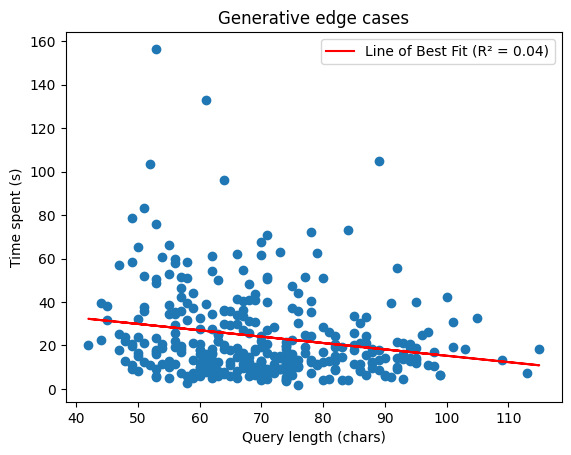

In [33]:
print(query_to_avgs['Non-interactive'])

query_type = 'Generative edge cases'
x = np.array([item[0] for item in query_to_avgs[query_type]])
y = np.array([item[1] for item in query_to_avgs[query_type]])

plt.scatter(x, y)
plt.xlabel('Query length (chars)')
plt.ylabel('Time spent (s)')
plt.title(query_type)

slope, intercept = np.polyfit(x, y, 1)
line_of_best_fit = slope * x + intercept
r2 = r2_score(y, line_of_best_fit)
plt.plot(x, line_of_best_fit, color='red', label=f'Line of Best Fit (R² = {r2:.2f})')
plt.legend()

plt.show()


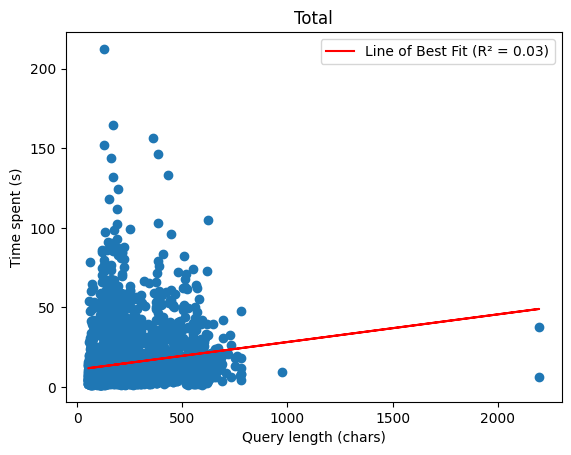

In [30]:
x = []
y = []
for query_type in ['Supervised Learning', 'Pool-based Active Learning', 'Generative edge cases', 'Generative yes/no questions', 'Generative open-ended questions']:
    x.extend([item[0] for item in query_to_avgs[query_type]])
    y.extend([item[1] for item in query_to_avgs[query_type]])

x = np.array(x)
y = np.array(y)

plt.scatter(x, y)
plt.xlabel('Query length (chars)')
plt.ylabel('Time spent (s)')
plt.title('Total')

slope, intercept = np.polyfit(x, y, 1)
line_of_best_fit = slope * x + intercept
r2 = r2_score(y, line_of_best_fit)
plt.plot(x, line_of_best_fit, color='red', label=f'Line of Best Fit (R² = {r2:.2f})')
plt.legend()

plt.show()


### Testing Perplexity Correlation with Time

In [8]:

import torch
import math
from transformers import AutoTokenizer, AutoModelForCausalLM
import pickle

cache_dir = "C:\\LLMs"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load Falcon-7B model and tokenizer from Hugging Face
model_name = "tiiuae/falcon-7b"
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
model = AutoModelForCausalLM.from_pretrained(model_name, cache_dir=cache_dir).to(device)


# Function to compute perplexity for a given sentence
# This code runs slow :( 3 min per query
def compute_perplexity(sentence):
    # Tokenize input and move input IDs to the same device as the model
    inputs = tokenizer(sentence, return_tensors="pt").to(device)
    input_ids = inputs["input_ids"]

    with torch.no_grad():
        # Model forward pass with inputs on the correct device
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss.item()  # Cross-entropy loss

    perplexity = math.exp(loss)  # Perplexity = exp(loss)
    return perplexity


c:\Users\georg\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:31<00:00, 15.89s/it]


In [9]:
perplexity = compute_perplexity("Please write down all the topics for websites that you would be interested in")
print(perplexity)

32.277402750475154


In [12]:
FILE_PATH = 'annotations_gpt-4/annotations_gpt-4'

with open(f'{FILE_PATH}/experiment_type_to_prolific_id.json') as file:
    experiment_types = json.load(file)

website_preferences = experiment_types['website_preferences']

query_to_perplexities = {}
cnt = 0
for query_type in website_preferences:
    if query_type != "Generative open-ended questions":
        continue
    print("QUERY TYPE:", query_type)
    query_perplexities = []

    for i, prolific_id in enumerate(website_preferences[query_type]):
        if (i == 0): continue
        with open(f'{FILE_PATH}/{prolific_id}.json') as file:
            person_data = json.load(file)

        history = person_data['conversation_history']
        person_perlexities = []

        assistant_perplexity = None
        for item in history:
            if item['sender'] == 'user':
                if assistant_perplexity is None:
                    continue
                time_spent = item['time_spent_ms'] / 1000
                person_perlexities.append((assistant_perplexity, time_spent))
                assistant_perplexity = None
            else: # item['sender'] == 'assistant'
                assistant_perplexity = compute_perplexity(item['message'])
                if cnt % 50 == 0:
                    print(cnt)
                cnt += 1

        query_perplexities.extend(person_perlexities)

    query_to_perplexities[query_type] = query_perplexities
    with open(f"{query_type}.pkl", "wb") as f:
        pickle.dump(query_perplexities, f)


QUERY TYPE: Generative open-ended questions
0
50
100
150
200


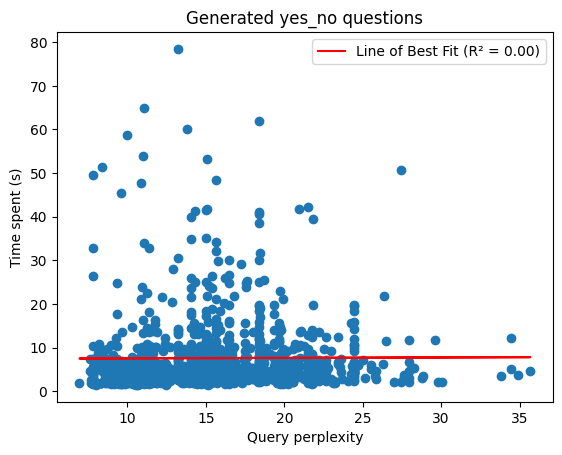

In [18]:
query_type = 'Generated yes_no questions'

with open(f"{query_type}.pkl", "rb") as f:
    query_to_perplexities = pickle.load(f)

x = np.array([item[0] for item in query_to_perplexities])
y = np.array([item[1] for item in query_to_perplexities])

plt.scatter(x, y)
plt.xlabel('Query perplexity')
plt.ylabel('Time spent (s)')
plt.title(query_type)

slope, intercept = np.polyfit(x, y, 1)
line_of_best_fit = slope * x + intercept
r2 = r2_score(y, line_of_best_fit)
plt.plot(x, line_of_best_fit, color='red', label=f'Line of Best Fit (R² = {r2:.2f})')
plt.legend()

plt.show()


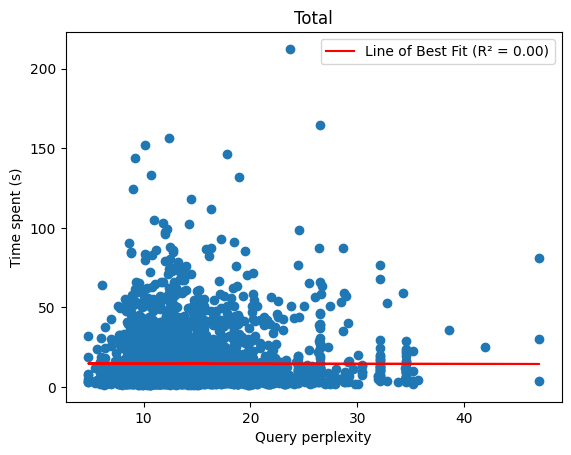

In [21]:
x = []
y = []
for query_type in ['Supervised Learning', 'Pool-based Active Learning', 'Generative edge cases', 'Generated yes_no questions', 'Generative open-ended questions']:
    with open(f"{query_type}.pkl", "rb") as f:
        query_to_perplexities = pickle.load(f)
    x.extend([item[0] for item in query_to_perplexities])
    y.extend([item[1] for item in query_to_perplexities])

x = np.array(x)
y = np.array(y)

plt.scatter(x, y)
plt.xlabel('Query perplexity')
plt.ylabel('Time spent (s)')
plt.title('Total')

slope, intercept = np.polyfit(x, y, 1)
line_of_best_fit = slope * x + intercept
r2 = r2_score(y, line_of_best_fit)
plt.plot(x, line_of_best_fit, color='red', label=f'Line of Best Fit (R² = {r2:.2f})')
plt.legend()

plt.show()
